In [1]:
import numpy as np
import scipy.linalg as scl
import geopandas as gpd
from models import spatialModelNO2alpha, estimateSpatialAlphas, calcConnectivity, calcReducedConnectivity
from plotting import getIndex
import pymc3 as pm
import matplotlib.pyplot as plt
# plt.style.use('seaborn-darkgrid')

In [2]:
data = gpd.read_file('./data/landkreise_no2_14d.json')
#dateColNames = np.concatenate(['04.03.2020'], )
dateColNames = data.columns[14:-1].values
dateColNames = np.concatenate((['04.03.2020'], dateColNames))
dateColNames

array(['04.03.2020', '05.03.2020', '06.03.2020', '07.03.2020',
       '08.03.2020', '09.03.2020', '10.03.2020', '11.03.2020',
       '12.03.2020', '13.03.2020', '14.03.2020', '15.03.2020',
       '16.03.2020', '17.03.2020', '18.03.2020', '19.03.2020',
       '20.03.2020', '21.03.2020', '22.03.2020', '23.03.2020',
       '24.03.2020', '25.03.2020', '26.03.2020', '27.03.2020',
       '28.03.2020', '29.03.2020', '30.03.2020', '31.03.2020',
       '01.04.2020', '02.04.2020', '03.04.2020', '04.04.2020',
       '05.04.2020', '06.04.2020', '07.04.2020', '08.04.2020',
       '09.04.2020', '10.04.2020', '11.04.2020', '12.04.2020',
       '13.04.2020', '14.04.2020', '15.04.2020', '16.04.2020',
       '17.04.2020', '18.04.2020', '19.04.2020', '20.04.2020',
       '21.04.2020', '22.04.2020', '23.04.2020', '24.04.2020'],
      dtype=object)

In [3]:
incubationTime = 7
t_curfew = getIndex('22.03.2020', dateColNames)
t_curfew_effect = t_curfew + incubationTime

dataBayern = data[data['partof'] == 'Bayern']
dataSchwaben = dataBayern[(dataBayern['AGS'] >= 9700) & (dataBayern['AGS'] < 9800)]
rawDataSchwaben = dataSchwaben[dateColNames].values
rawDataSchwabenBefore = dataSchwaben[dateColNames[:t_curfew_effect]].values
rawDataSchwabenAfter = dataSchwaben[dateColNames[t_curfew_effect:]].values

nrPlaces, nrTimesteps = rawDataSchwaben.shape
n0Schwaben = rawDataSchwabenBefore[:, 0]
KSchwaben = dataSchwaben['population'].values
geometriesSchwaben = dataSchwaben.geometry.values
placeNames = dataSchwaben['ADMIN'].values


In [4]:
#   A * A_ri = I_r
# rxc   cxr
# r <= c

def rightInverse(x):
    R, C = x.shape
    if R > C:
        raise Error('Right inverse only exists for broad matrices')
    xT = x.T
    x_xT = np.matmul(x, xT)
    x_xT_inv = np.linalg.inv(x_xT)
    ri = np.matmul(xT, x_xT_inv)
    return ri


def leftInverse(x):
    R, C = x.shape
    if R < C:
        raise Error('Left inverse only exists for tall matrices')
    xT = x.T
    xT_x = np.matmul(xT, x)
    xT_x_inv = np.linalg.inv(xT_x)
    li = np.matmul(xT_x_inv, xT)
    return li

In [7]:
def calcChangeNormd(n_obs, Ks, delta=1):
    nrPlaces, nrTimesteps = n_obs.shape
    change_normd = np.zeros((nrPlaces, nrTimesteps))
    for x in range(nrPlaces):
        for t in range(nrTimesteps):
            nt = n_obs[x, t]
            ntm1 = n_obs[x, t - delta] if (t - delta)>=0 else 0
            change_normd[x, t] = (Ks[x] / (Ks[x] - nt)) * (nt - ntm1)
    return change_normd


def calcConn(change_normd, n_obs):
    n_ri = rightInverse(n_obs)
    conn = np.matmul(change_normd, n_ri)
    return conn


def splitAlpha(conn):
    nrPlaces, _ = conn.shape
    alphas = np.diag(conn)
    conn1 = np.zeros((nrPlaces, nrPlaces))
    for r in range(nrPlaces):
        for c in range(nrPlaces):
            conn1[r, c] = conn[r, c] / alphas[r]
    return alphas, conn1



In [8]:
changeNormedSchwabenBefore = calcChangeNormd(rawDataSchwabenBefore, KSchwaben)
connNonnormedSchwabenBefore = calcConn(changeNormedSchwabenBefore, rawDataSchwabenBefore)
alphaSchwabenBefore, connSchwabenBefore = splitAlpha(connNonnormedSchwabenBefore)

In [9]:
changeNormedSchwabenAfter = calcChangeNormd(rawDataSchwabenAfter, KSchwaben)
connNonnormedSchwabenAfter = calcConn(changeNormedSchwabenAfter, rawDataSchwabenAfter)
alphaSchwabenAfter, connSchwabenAfter = splitAlpha(connNonnormedSchwabenAfter)

[Text(0, 0, 'Memmingen (Kreisfreie Stadt)'),
 Text(0, 0, 'Günzburg (Landkreis)'),
 Text(0, 0, 'Dillingen a.d. Donau (Landkreis)'),
 Text(0, 0, 'Augsburg (Kreisfreie Stadt)'),
 Text(0, 0, 'Aichach-Friedberg (Landkreis)'),
 Text(0, 0, 'Neu-Ulm (Landkreis)'),
 Text(0, 0, 'Augsburg (Landkreis)'),
 Text(0, 0, 'Kempten (Allgäu) (Kreisfreie Stadt)'),
 Text(0, 0, 'Unterallgäu (Landkreis)')]

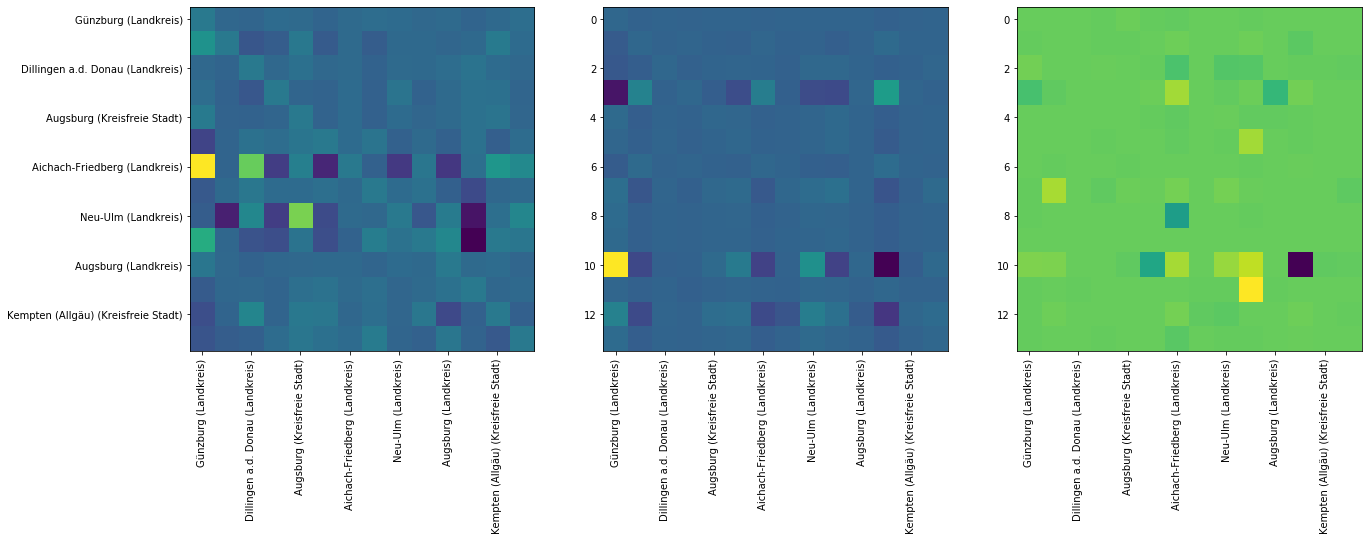

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
axes[0].imshow(connSchwabenBefore)
axes[0].set_xticklabels(placeNames, rotation=90)
axes[0].set_yticklabels(placeNames)
axes[1].imshow(connSchwabenAfter)
axes[1].set_xticklabels(placeNames, rotation=90)
axes[2].imshow(connSchwabenAfter / connSchwabenBefore)
axes[2].set_xticklabels(placeNames, rotation=90)

(array([  1.,   0.,   0.,   0.,   0.,   2.,   1., 183.,   7.,   2.]),
 array([-1215.97831759, -1057.20591111,  -898.43350463,  -739.66109815,
         -580.88869167,  -422.1162852 ,  -263.34387872,  -104.57147224,
           54.20093424,   212.97334071,   371.74574719]),
 <a list of 10 Patch objects>)

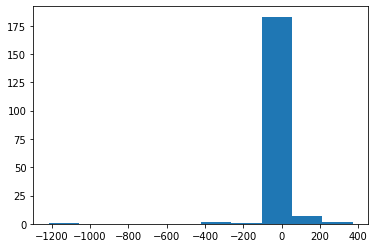

In [11]:
plt.hist((connSchwabenAfter / connSchwabenBefore).flatten())

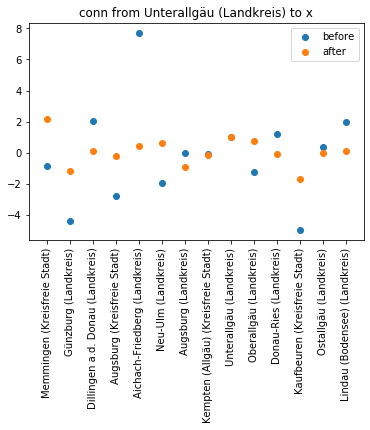

In [12]:
i = 8
plt.scatter(range(nrPlaces), connSchwabenBefore[i], label='before')
plt.scatter(range(nrPlaces), connSchwabenAfter[i], label='after')
plt.xticks(range(nrPlaces), placeNames, rotation=90)
plt.title(f"conn from {placeNames[i]} to x")
plt.legend()

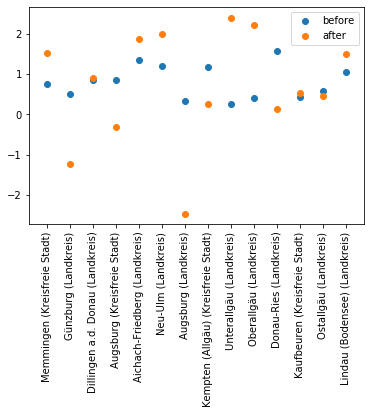

In [13]:
x = np.arange(nrPlaces)
plt.scatter(x, alphaSchwabenBefore, label='before')
plt.scatter(x, alphaSchwabenAfter, label='after')
plt.xticks(range(nrPlaces), placeNames, rotation=90)
plt.legend()

Text(0.5, 1.0, 'Connectivity to Augsburg (Kreisfreie Stadt)')

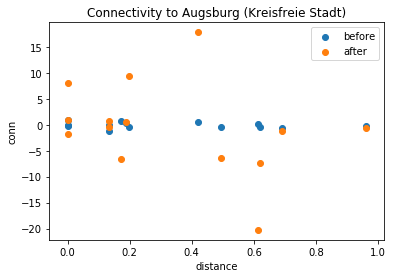

In [64]:
i = 3
place0 = dataSchwaben.iloc[i]
distances = []
connB = []
connA = []
for l in range(nrPlaces):
    place1 = dataSchwaben.iloc[l]
    d = place1.geometry.distance(place0.geometry)
    cb = connSchwabenBefore[i, l]
    ca = connSchwabenAfter[i, l]
    distances.append(d)
    connB.append(cb)
    connA.append(ca)


plt.scatter(distances, connB, label='before')
plt.scatter(distances, connA, label='after')
plt.legend()
plt.xlabel('distance')
plt.ylabel('conn')
plt.title(f"Connectivity to {place0['ADMIN']}")


In [14]:
from models import spatialModel

In [15]:
sim = spatialModel(alphaSchwabenBefore, alphaSchwabenAfter, connSchwabenBefore, connSchwabenAfter,
                nrPlaces, nrTimesteps, n0Schwaben, KSchwaben, geometriesSchwaben, t_curfew_effect, t_curfew)
sim.shape

(14, 52)

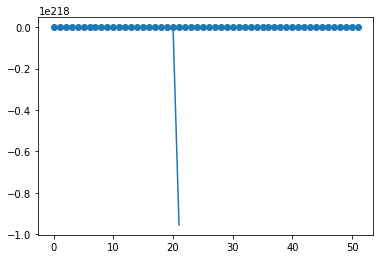

In [16]:
t = np.arange(nrTimesteps)
for x in range(2, 3):
    plt.scatter(t, rawDataSchwaben[x])
    plt.plot(t, sim[x])

In [23]:
# optimized parameters
fracSpatial1 = 0.07785674
fracSpatial2 = 0.4297616 
fracNO2Traffic = 0.76424961

no2_before = dataSchwaben['obs_no2_mean_before']
no2_after = dataSchwaben['obs_no2_mean_after']

sim, connectivity0, connectivity1, alphas0, alphas1 = spatialModelNO2alpha(
                                    fracSpatial1, fracSpatial2, fracNO2Traffic,
                                    KSchwaben, geometriesSchwaben, t_curfew_effect, t_curfew, 
                                    rawDataSchwaben, no2_before, no2_after, True)

... 1 calls made ...


In [25]:
alphaSchwabenAfter / alphaSchwabenBefore

array([0.74949448, 0.51844374, 0.86097556, 0.85006295, 1.34855326,
       1.21286309, 0.33334668, 1.18284609, 0.25545963, 0.41279932,
       1.56895727, 0.44390826, 0.57857598, 1.06336043])

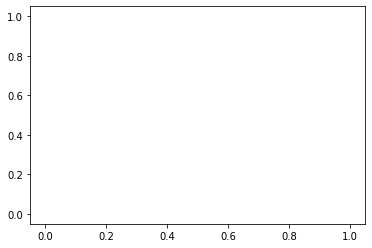

In [28]:
plt.scatter(alphas1 / alphas0, alphaSchwabenAfter / alphaSchwabenBefore)